In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import os
import statsmodels.api as sm
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d
from itertools import product
import statsmodels.formula.api as smf
from patsy import dmatrix
from pygam import LinearGAM, s, f
import matplotlib.dates as mdates


##############################
# 1. 데이터 불러오기
##############################

def holiday_dates(holiday_file="/Users/gimsyoni/Desktop/biomathlab/code/outputs/cached/holiday.csv"):
    # 파일이 존재하지 않으면 다운로드 함수 호출 
    # download_holiday_dates(holiday_file) 

    # CSV 파일 읽기
    df = pd.read_csv(holiday_file,encoding='cp949', dtype={'holiday': str}, parse_dates=['date'])
    return df

holiday = holiday_dates()

interventions = pd.read_csv('/Users/gimsyoni/Desktop/biomathlab/code/outputs/cached/intervention_stage.csv',encoding='UTF-8', dtype={'state': str,'level':str}, parse_dates=['start_date','end_date'])


# URL에서 데이터 읽어오기
def google_mobility():
    url = "https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv"
    data = pd.read_csv(url, 
                       parse_dates=['date'], # date 열을 날짜 형식으로 파싱
                       usecols=['country_region', 'date', 'metro_area',
                                'retail_and_recreation_percent_change_from_baseline', 
                                'grocery_and_pharmacy_percent_change_from_baseline', 
                                'parks_percent_change_from_baseline', 
                                'transit_stations_percent_change_from_baseline', 
                                'workplaces_percent_change_from_baseline', 
                                'residential_percent_change_from_baseline']
                      )

    # 필터링
    data = data[(data['country_region'] == 'South Korea')]

    # 데이터 재구성
    data = data.melt(id_vars=['metro_area', 'date'], 
                     value_vars=['retail_and_recreation_percent_change_from_baseline', 
                                 'grocery_and_pharmacy_percent_change_from_baseline', 
                                 'parks_percent_change_from_baseline', 
                                 'transit_stations_percent_change_from_baseline', 
                                 'workplaces_percent_change_from_baseline', 
                                 'residential_percent_change_from_baseline'],
                     var_name='category', 
                     value_name='trend')

    # 열 이름 변경
    data.columns = ['state', 'date', 'category', 'trend']

    # 카테고리 열 수정
    data['category'] = data['category'].str.replace('_percent_change_from_baseline', '').str.replace('_', ' ')

    return data


# google mobility data가 없다면 다음 두줄 주석해제 -> 다운받는데 오래 걸리기때문에 첨부한 데이터인 cached_mobility.csv를 쓰길 권장
# cahched_mobility = google_mobility() 
# cahched_mobility.to_csv('/Users/gimsyoni/Desktop/biomathlab/code/outputs/cached/cached_mobility.csv',index=False)

# 함수 호출
mobility=pd.read_csv('/Users/gimsyoni/Desktop/biomathlab/code/outputs/cached_mobility.csv')

# - remove the grocery and pharmacy category
# (affected by panic buying, not interventions)
mobility=mobility[mobility['datastream'] != 'Google: time at grocery and pharmacy']
mobility['state'] = mobility['state'].fillna('total')
mobility['state_long'] = mobility['state']
mobility.loc[mobility['state_long'] == 'Seoul Metropolitan Area', 'state'] = 'metro'
mobility['date']=pd.to_datetime(mobility['date'])

combinations = list(product(mobility['datastream'].unique(), mobility['state'].unique()))

category_mapping = {     # 데이터스트림과 새 카테고리의 매핑
        "Google: time at residential": "home",
        "Google: time at transit stations": "transit",
        "Google: time at parks": "public",
        "Google: time at workplaces": "work",
        "Google: time at retail and recreation": "retail"
    }
    


def write_mobility_dates(mobility, dir="outputs/"): #google mobility data를 카테고리별로 저장
    # 'state'가 'none'인 경우 'total'로 변경
    # 모든 가능한 조합 생성
    combinations = list(product([k for k, v in category_mapping.items()], mobility['state'].unique()))
    
    # 각 조합에 대해 데이터프레임 생성 및 저장
    for datastream, state in combinations:
        # 해당 조합의 데이터프레임 추출
        df = mobility[(mobility['datastream'] == datastream) & (mobility['state'] == state)]        
        # 파일명 생성
        filename = f"/Users/gimsyoni/Desktop/biomathlab/code/outputs/cached/mobility_dates_{category_mapping[datastream]}_{state}.csv"
        
        # CSV로 저장
        df.to_csv(os.path.join(dir, filename), index=False)


# google mobility 카테고리별 csv가 없다면 아래 주석 해제 
# write_mobility_dates(mobility)


##############################
# 2. Google Mobility 정리
##############################
# Google 데이터는 datastream과 state 조합으로 저장됩니다.

def call_mobility_df(datastream,state):
    filename = f"/Users/gimsyoni/Desktop/biomathlab/code/outputs/cached/mobility_dates_{category_mapping[datastream]}_{state}.csv"
    df=pd.read_csv(filename)
    return df

#저장한 카데고리별 mobility 불러오기
for datastream,state in combinations:
    globals()['{}_{}_df'.format(category_mapping[datastream],state)] = call_mobility_df(datastream,state)


n_weeks_ahead = 6
first_date = min(mobility['date'])
last_date = max(mobility['date'])

min_date = first_date
max_date = last_date + timedelta(days=7 * n_weeks_ahead) 

all_dates = pd.date_range(min_date, max_date)


#mobility df 불러오는 함수
def load_mobility_df(datastream, state):
    # Define the filename based on datastream and state
    return globals()['{}_{}_df'.format(category_mapping[datastream],state)]


##############################
# 3. 이상치 제거
##############################

def Cal_outlier(df,selected_columns):
    outliers = {}  # 이상값 개수를 저장할 딕셔너리
    for column in selected_columns:
        q1 = df[column].quantile(0.25)  # 1사분위수
        q3 = df[column].quantile(0.75)  # 3사분위수
        iqr = q3 - q1  # IQR 계산
        lower_bound = q1 - 1.5 * iqr  # 하계치
        upper_bound = q3 + 1.5 * iqr  # 상계치

        outlier_count = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
        outliers[column] = outlier_count

    for column, count in outliers.items():
        if count >0:
            print("Outliers:")
            print(f"{column}: {count}")
    return count



# 이상값들을 상한값보다 크면 상한값으로, 하한값보다 작으면 하한값으로 대체
def replace_outliers(df,columns):
    for column in columns:
        q1 = df[column].quantile(0.25)  # 1사분위수
        q3 = df[column].quantile(0.75)  # 3사분위수
        iqr = q3 - q1  # IQR 계산
        lower_bound = q1 - 1.5 * iqr  # 하계치
        upper_bound = q3 + 1.5 * iqr  # 상계치

    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

cnt=0
for datastream,state in combinations:
    replace_outliers(globals()['{}_{}_df'.format(category_mapping[datastream],state)],['trend'])
    #이상치 있는지 확인
    count = Cal_outlier(globals()['{}_{}_df'.format(category_mapping[datastream],state)],['trend'])
    cnt+=count
if cnt==0:
    print("There is no outlier")


There is no outlier


In [ ]:
def preprocessing(mobility,state):
# Left join with public holidays
    raw_interventions = pd.read_csv('/Users/gimsyoni/Desktop/biomathlab/code/outputs/cached/intervention_stage.csv',encoding='UTF-8', dtype={'state': str,'level':str}, parse_dates=['start_date','end_date'])
    raw_interventions=raw_interventions[raw_interventions['state']==state]
    interventions=pd.DataFrame({})
    for _, row in raw_interventions.iterrows():
        tmp=pd.DataFrame({})
        tmp['date']=pd.date_range(row['start_date'], row['end_date'])
        len = (row['end_date'] - row['start_date']).days

        tmp['level']=row['level']
        tmp['state']=row['state']
        tmp['stage2'] = (tmp['date'] - row['start_date']).dt.days+1

        interventions = pd.concat([interventions, tmp], ignore_index=True)
        
    interventions.rename(columns={'level':'stage1'},inplace=True)

    mobility['date']=pd.to_datetime(mobility['date'])
    df = mobility.merge(holiday, on=["date"], how="left")
    
    # Left join with intervention steps
    df = df.merge(interventions, on=["state","date"], how="left")

    # Replace NA values in 'holiday' column with 'none'
    df['holiday'] = df['holiday'].fillna('none')

    # Create binary columns indicating if it's a holiday or school holiday
    df['is_a_holiday'] = df['holiday'] != 'none'

    # Calculate numeric representation of date relative to min_date
    df['date_num'] = (df['date'] - min_date).dt.days

    # Extract day of the week as a character
    df['dow'] = df['date'].dt.day_name()

    return df


from pygam import LinearGAM, s, f
def pred_mobility(df):
    # Convert 'dow' variable into dummy variables
    df_dow = pd.get_dummies(df[['dow']])

    # Fill null values in 'stage2' with 0
    df['stage2'] = df['stage2'].fillna(0)

    # Concatenate dummy variables with the original dataframe
    df_fitted = pd.concat([df, df_dow], axis=1)

    # Define features and target variable
    X = df_fitted[['date_num', 'is_a_holiday','stage2'] + df_dow.columns.tolist()]  # Features
    y = df_fitted['trend']  # Target variable

    # Define features using splines for continuous variables and factor for categorical variables
    features = s(0, n_splines=50) + f(1) + s(2) + f(3) + f(4) + f(5) + f(6) +f(7) + f(8) + f(9) 

    # Create LinearGAM model
    gam = LinearGAM(features)

    # Fit the model
    gam.fit(X, y)

    # Print summary of the model
    print(gam.summary())

    # Predict with the model
    predictions = gam.predict(X)

    # Create a new dataframe with fitted values and confidence intervals
    df_fitted['fitted_trend'] = predictions
    df_fitted['fitted_trend_upper'] = predictions + 1.96 * gam.statistics_['scale']
    df_fitted['fitted_trend_lower'] = predictions - 1.96 * gam.statistics_['scale']

    pred_df = pd.DataFrame({# 'state_long': df['state_long'].unique(),# 'dow': df['dow'].unique(),
                            'date': all_dates})

    # Left join with public_holidays and intervention stage dataframe
    pred_df = pd.merge(pred_df, holiday, on=[ 'date'], how='left')
    pred_df = pd.merge(pred_df, df[['date','stage1','stage2']], on=[ 'date'], how='left')

    pred_df = pd.concat([pred_df, df_dow], axis=1)
    # Mutate and transform columns

    pred_df['holiday'].fillna('none', inplace=True)
    pred_df['stage2'].fillna(0, inplace=True)

    pred_df['is_a_holiday'] = pred_df['holiday'] != 'none'

    # Calculate date_num and clamp the smooth part of the prediction at both ends
    pred_df['date_num'] = pred_df['date'].sub(min_date).dt.days
    pred_df['dow'] = pred_df['date'].dt.dayofweek.map({0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'})

    pred_df_dow = pd.get_dummies(pred_df[['dow']])
    pred_df = pd.concat([pred_df, pred_df_dow], axis=1)

    # Predict trend using gam_model
    pred_df['predicted_trend'] = gam.predict(pred_df[['date_num','is_a_holiday','stage2']+pred_df_dow.columns.tolist()])

    # Smooth the predicted trend using gaussian smoothing
    pred_df['predicted_trend'] = gaussian_filter1d(pred_df['predicted_trend'], sigma=2.8, mode='nearest', axis=0)

    # Left join with df_fitted dataframe
    pred_df = pd.merge(pred_df, df_fitted[['datastream','state', 'state_long', 'date', 'trend', 'fitted_trend', 'fitted_trend_lower', 'fitted_trend_upper']],
                    on=['date'], how='left')

    return pred_df




##############################
# 4. 각 df 전처리
##############################
# 날짜별로 공휴일 정보, 거리두기 단계(stage), 요일 등을 합쳐줌
# dow (요일) 더미 변수 생성
# date_num으로 날짜를 수치화

for datastream,state in combinations:
    globals()['{}_{}_df'.format(category_mapping[datastream],state)] = preprocessing(load_mobility_df(datastream, state),state)


###########################
# 5. 모델 학습 및 예측
###########################
# X: date_num, is_a_holiday, stage2, 요일 더미
# y: 원본 mobility trend 값
for datastream,state in combinations:
    globals()['{}_{}_predicted_df'.format(category_mapping[datastream],state)] = pred_mobility(globals()['{}_{}_df'.format(category_mapping[datastream],state)])


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     47.6961
Link Function:                     IdentityLink Log Likelihood:                                 -4237.5896
Number of Samples:                          988 AIC:                                             8572.5714
                                                AICc:                                            8577.7296
                                                GCV:                                               31.3107
                                                Scale:                                             28.6022
                                                Pseudo R-Squared:                                   0.8154
Feature Function                  Lam

/var/folders/9l/y7rn0rr91k73p0jz0hjkjmy00000gn/T/ipykernel_19227/3723026455.py:65: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     48.2648
Link Function:                     IdentityLink Log Likelihood:                                  -4272.031
Number of Samples:                         1000 AIC:                                             8642.5915
                                                AICc:                                            8647.8062
                                                GCV:                                               30.7725
                                                Scale:                                             28.1111
                                                Pseudo R-Squared:                                   0.7804
Feature Function                  Lam

/var/folders/9l/y7rn0rr91k73p0jz0hjkjmy00000gn/T/ipykernel_19227/3723026455.py:65: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     47.6961
Link Function:                     IdentityLink Log Likelihood:                                 -6472.6125
Number of Samples:                          988 AIC:                                            13042.6172
                                                AICc:                                           13047.7755
                                                GCV:                                              305.2278
                                                Scale:                                            278.8244
                                                Pseudo R-Squared:                                   0.6008
Feature Function                  Lam

/var/folders/9l/y7rn0rr91k73p0jz0hjkjmy00000gn/T/ipykernel_19227/3723026455.py:65: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     48.2648
Link Function:                     IdentityLink Log Likelihood:                                 -6898.8893
Number of Samples:                         1000 AIC:                                            13896.3081
                                                AICc:                                           13901.5228
                                                GCV:                                              432.3353
                                                Scale:                                            394.9447
                                                Pseudo R-Squared:                                    0.527
Feature Function                  Lam

/var/folders/9l/y7rn0rr91k73p0jz0hjkjmy00000gn/T/ipykernel_19227/3723026455.py:65: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     47.6961
Link Function:                     IdentityLink Log Likelihood:                                 -3788.8271
Number of Samples:                          988 AIC:                                             7675.0464
                                                AICc:                                            7680.2047
                                                GCV:                                               19.6863
                                                Scale:                                             17.9833
                                                Pseudo R-Squared:                                   0.7728
Feature Function                  Lam

/var/folders/9l/y7rn0rr91k73p0jz0hjkjmy00000gn/T/ipykernel_19227/3723026455.py:65: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     48.2648
Link Function:                     IdentityLink Log Likelihood:                                 -3860.5454
Number of Samples:                         1000 AIC:                                             7819.6204
                                                AICc:                                            7824.8351
                                                GCV:                                               20.2123
                                                Scale:                                             18.4642
                                                Pseudo R-Squared:                                   0.7957
Feature Function                  Lam

/var/folders/9l/y7rn0rr91k73p0jz0hjkjmy00000gn/T/ipykernel_19227/3723026455.py:65: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     47.6961
Link Function:                     IdentityLink Log Likelihood:                                  -3488.513
Number of Samples:                          988 AIC:                                             7074.4182
                                                AICc:                                            7079.5765
                                                GCV:                                               14.3853
                                                Scale:                                             13.1409
                                                Pseudo R-Squared:                                   0.8191
Feature Function                  Lam

/var/folders/9l/y7rn0rr91k73p0jz0hjkjmy00000gn/T/ipykernel_19227/3723026455.py:65: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     48.2648
Link Function:                     IdentityLink Log Likelihood:                                 -3460.4659
Number of Samples:                         1000 AIC:                                             7019.4615
                                                AICc:                                            7024.6761
                                                GCV:                                               13.3701
                                                Scale:                                             12.2138
                                                Pseudo R-Squared:                                   0.8171
Feature Function                  Lam

/var/folders/9l/y7rn0rr91k73p0jz0hjkjmy00000gn/T/ipykernel_19227/3723026455.py:65: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     47.6961
Link Function:                     IdentityLink Log Likelihood:                                 -2165.2194
Number of Samples:                          988 AIC:                                             4427.8311
                                                AICc:                                            4432.9894
                                                GCV:                                                3.3444
                                                Scale:                                              3.0551
                                                Pseudo R-Squared:                                   0.7937
Feature Function                  Lam

/var/folders/9l/y7rn0rr91k73p0jz0hjkjmy00000gn/T/ipykernel_19227/3723026455.py:65: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     48.2648
Link Function:                     IdentityLink Log Likelihood:                                 -2234.0532
Number of Samples:                         1000 AIC:                                             4566.6361
                                                AICc:                                            4571.8508
                                                GCV:                                                3.5164
                                                Scale:                                              3.2123
                                                Pseudo R-Squared:                                    0.803
Feature Function                  Lam

/var/folders/9l/y7rn0rr91k73p0jz0hjkjmy00000gn/T/ipykernel_19227/3723026455.py:65: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


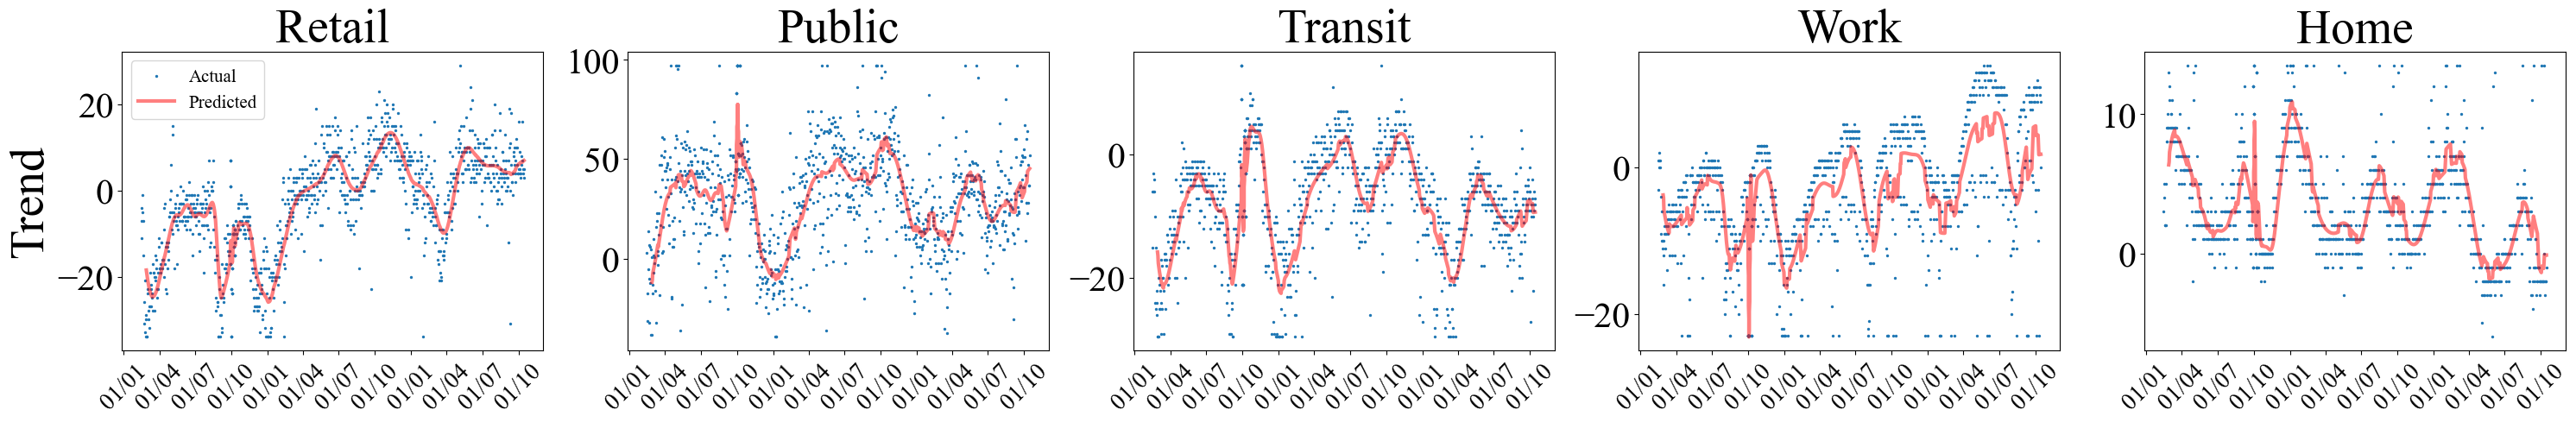

In [8]:
####GAM 적용시킨 trend값 플랏
def plot_trend(ax,datastream,df):
# Plot actual vs. predicted values
    ax.scatter(df['date'], df['trend'], label='Actual',s=2)
    ax.plot(df['date'], df['fitted_trend'].rolling(window=14).mean(), label='Predicted',color='red',alpha=0.5,linewidth=3)
    datastream=datastream[0].upper()+datastream[1:]
    
    ax.set_title('{}'.format(datastream), fontsize=40)


    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=30)

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)


plt.rcParams['font.family'] = 'Times New Roman'
fig, axs = plt.subplots(1, 5, figsize=(30, 5))


# 서브플롯에 데이터 플롯
for i, (datastream, state) in enumerate(combinations):
    tmp = globals()['{}_{}_predicted_df'.format(category_mapping[datastream], state)]
    if state=='total':
        num = int((i+1)/2)
        plot_trend(axs[num],category_mapping[datastream], tmp)
        if num == 0:
            axs[0].legend(fontsize=15)
            axs[0].set_ylabel('Trend', fontsize=40)

plt.tight_layout()
plt.show()


In [ ]:

tmp1 = retail_total_predicted_df[['date','trend','fitted_trend','fitted_trend_lower','fitted_trend_upper']]
tmp1.rename(columns={'trend':'retail_trend','fitted_trend':'retail_fitted_trend','fitted_trend_lower':'retail_fitted_lower','fitted_trend_upper':'retail_fitted_upper'},inplace=True)
tmp1 = tmp1.groupby('date').mean().reset_index()

tmp2 = public_total_predicted_df[['date','trend','fitted_trend','fitted_trend_lower','fitted_trend_upper']]
tmp2.rename(columns={'trend':'public_trend','fitted_trend':'public_fitted_trend','fitted_trend_lower':'public_fitted_lower','fitted_trend_upper':'public_fitted_upper'},inplace=True)
tmp2 = tmp2.groupby('date').mean().reset_index()

tmp3 = transit_total_predicted_df[['date','trend','fitted_trend','fitted_trend_lower','fitted_trend_upper']]
tmp3.rename(columns={'trend':'transit_trend','fitted_trend':'transit_fitted_trend','fitted_trend_lower':'transit_fitted_lower','fitted_trend_upper':'transit_fitted_upper'},inplace=True)
tmp3 = tmp3.groupby('date').mean().reset_index()

tmp4 = work_total_predicted_df[['date','trend','fitted_trend','fitted_trend_lower','fitted_trend_upper']]
tmp4.rename(columns={'trend':'work_trend','fitted_trend':'work_fitted_trend','fitted_trend_lower':'work_fitted_lower','fitted_trend_upper':'work_fitted_upper'},inplace=True)
tmp4 = tmp4.groupby('date').mean().reset_index()

tmp5 = home_total_predicted_df[['date','trend','fitted_trend','fitted_trend_lower','fitted_trend_upper']]
tmp5.rename(columns={'trend':'home_trend','fitted_trend':'home_fitted_trend','fitted_trend_lower':'home_fitted_lower','fitted_trend_upper':'home_fitted_upper'},inplace=True)
tmp5 = tmp5.groupby('date').mean().reset_index()


merged_df = tmp1.merge(tmp2, on='date').merge(tmp3, on='date').merge(tmp4, on='date').merge(tmp5, on='date')

duplicate_dates = tmp1['date'].duplicated()
has_duplicates = duplicate_dates.any()

print(f"중복 여부: {has_duplicates}")
if has_duplicates:
    print("중복된 날짜들:")
    print(tmp1['date'][duplicate_dates])

def cal_mobility(row):
    retail, public, transit, work = row['retail_fitted_trend'], row['public_fitted_trend'], row['transit_fitted_trend'], row['work_fitted_trend']
    google_mobility_data = [retail, public, transit, work]
    mobility_coefs = np.abs(np.random.normal(0, 1, size=4))
    baseline_contact_params = [[2.09, 10.7, 1.05, 0.687], [0.06, 0.28, 1.68, 0.05]]
    OC_0 = np.random.normal(baseline_contact_params[0][1], baseline_contact_params[1][1])

    log_change_contacts = np.dot(google_mobility_data, mobility_coefs)
    log_OC_0 = np.log(OC_0)
    result = log_OC_0 + log_change_contacts
    print(log_OC_0)
    return result

def cal_mobility_upper(row):
    retail, public, transit, work = row['retail_fitted_upper'], row['public_fitted_upper'], row['transit_fitted_upper'], row['work_fitted_upper']
    google_mobility_data = [retail, public, transit, work]
    mobility_coefs = np.abs(np.random.normal(0, 1, size=4))
    baseline_contact_params = [[2.09, 10.7, 1.05, 0.687], [0.06, 0.28, 1.68, 0.05]]
    OC_0 = np.random.normal(baseline_contact_params[0][1], baseline_contact_params[1][1])

    log_change_contacts = np.dot(google_mobility_data, mobility_coefs)
    log_OC_0 = np.log(OC_0)
    result = log_OC_0 + log_change_contacts
    return result

def cal_mobility_lower(row):
    retail, public, transit, work = row['retail_fitted_lower'], row['public_fitted_lower'], row['transit_fitted_lower'], row['work_fitted_lower']
    google_mobility_data = [retail, public, transit, work]
    mobility_coefs = np.abs(np.random.normal(0, 1, size=4))
    baseline_contact_params = [[2.09, 10.7, 1.05, 0.687], [0.06, 0.28, 1.68, 0.05]]
    OC_0 = np.random.normal(baseline_contact_params[0][1], baseline_contact_params[1][1])

    log_change_contacts = np.dot(google_mobility_data, mobility_coefs)
    log_OC_0 = np.log(OC_0)
    result = log_OC_0 + log_change_contacts
    return result


# 4가지 mobility trend를 기반으로 무작위 생성된 가중치(계수)를 곱해 기준 접촉량의 로그값에 더한 결과, 결과값은 로그 스케일에서 mobility로 인한 접촉 변화 추정치
merged_df['fitted_trend'] = merged_df.apply(cal_mobility, axis=1)
merged_df['fitted_trend_upper'] = merged_df.apply(cal_mobility_upper, axis=1)
merged_df['fitted_trend_lower'] = merged_df.apply(cal_mobility_lower, axis=1)

# 결과 저장
# merged_df.to_csv('Mobility_trend0628.csv',index=False)
merged_df


NameError: name 'retail_total_predicted_df' is not defined